In [1]:
%cd C:/Users/Mathieu/Desktop/Projets/Benter

C:\Users\Mathieu\Desktop\Projets\Benter


In [2]:
%matplotlib inline
import collections
import functools

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
from tqdm import tqdm


from utils import import_data
from winning_horse_models.logistic_regression import LogisticRegressionModel
from constants import PMU_BETTINGS, SOURCE_PMU
from utils.wagering_stategy import compute_expected_return, compute_scenario, plot_scenario
import wagering_stategies
from wagering_stategies import factories as wagering_factories

from matplotlib import style
style.use('ggplot')

C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mathieu\Anaconda3\envs\deeplearning\l

In [3]:
winning_model = LogisticRegressionModel.load_model(trainable=False)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
%%time
expected_return_df=compute_expected_return(compute_betting_fun=wagering_stategies.race_betting_best_expected_return,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model)

TypeError: compute_expected_return() got an unexpected keyword argument 'compute_betting'

In [7]:
%%time
best_proba_expected_return_df=compute_expected_return(compute_betting_fun=wagering_stategies.race_betting_best_winning_proba,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model)

TypeError: compute_expected_return() got an unexpected keyword argument 'compute_betting'

In [6]:
%%time
pmp_expected_return_df = compute_expected_return(compute_betting=wagering_stategies.race_proportional_pari_mutual_proba,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model)

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 28min 36s


In [7]:
expected_return_df.expected_return.mean()

-0.09374706206704804

In [8]:
best_proba_expected_return_df.expected_return.mean()

-0.10029823830923484

In [9]:
pmp_expected_return_df.expected_return.mean()

-0.13812716717408502

In [10]:
for n_horse, n_horse_er_df in expected_return_df.groupby('n_horse'):
    print(n_horse,n_horse_er_df.expected_return.mean() , len(n_horse_er_df), f"{len(n_horse_er_df)/len(expected_return_df):.2%}" )


3 1.3711944089478063 2 0.02%
4 -0.4609364447733764 30 0.25%
5 -0.3803585038813666 183 1.53%
6 0.33803321758214805 435 3.65%
7 -0.0871380826758349 772 6.47%
8 -0.13222685643314838 1060 8.89%
9 -0.27005077286668355 1044 8.75%
10 -0.2713194993154043 1262 10.58%
11 0.14963816924552562 1164 9.76%
12 -0.052390941090385265 1452 12.17%
13 -0.12372743244229327 808 6.77%
14 0.16649715072277052 1069 8.96%
15 -0.35283558373274027 621 5.21%
16 -0.15600478364865203 1360 11.40%
17 -0.27612274664256203 153 1.28%
18 -0.03876152496441439 477 4.00%
19 -1.0 9 0.08%
20 -1.0 23 0.19%
22 -1.0 1 0.01%
24 -1.0 4 0.03%


In [11]:
for n_horse, n_horse_er_df in best_proba_expected_return_df.groupby('n_horse'):
    print(n_horse,n_horse_er_df.expected_return.mean() , len(n_horse_er_df), f"{len(n_horse_er_df)/len(best_proba_expected_return_df):.2%}" )


3 -0.32814324425341057 2 0.02%
4 -0.3101372644320488 30 0.25%
5 -0.24247557083347862 183 1.53%
6 0.08318772132944317 435 3.65%
7 0.010344148197146512 772 6.47%
8 -0.1531445122434451 1060 8.89%
9 -0.06818432674319042 1044 8.75%
10 -0.15366710872526013 1262 10.58%
11 -0.0840077287229511 1164 9.76%
12 -0.12066575641151413 1452 12.17%
13 -0.11327404948581252 808 6.77%
14 -0.08299176613391239 1069 8.96%
15 -0.11830745319940639 621 5.21%
16 -0.06346485967400196 1360 11.40%
17 -0.31655539919178766 153 1.28%
18 -0.17806784262764005 477 4.00%
19 0.7012127357589321 9 0.08%
20 -0.8846841468512608 23 0.19%
22 -1.0 1 0.01%
24 0.6433797748803096 4 0.03%


In [12]:
for n_horse, n_horse_er_df in pmp_expected_return_df.groupby('n_horse'):
    print(n_horse,n_horse_er_df.expected_return.mean() , len(n_horse_er_df), f"{len(n_horse_er_df)/len(pmp_expected_return_df):.2%}" )


3 -0.14014721848095563 2 0.02%
4 -0.1403366071870376 30 0.25%
5 -0.13899383431189016 183 1.53%
6 -0.14048325845425041 435 3.65%
7 -0.13839789285920365 772 6.47%
8 -0.13815260060401244 1060 8.89%
9 -0.13886415123262685 1044 8.75%
10 -0.13872974704342414 1262 10.58%
11 -0.13733473898410736 1164 9.76%
12 -0.1341555925471077 1452 12.17%
13 -0.1403622763636585 808 6.77%
14 -0.1403264847868757 1069 8.96%
15 -0.13907671308212552 621 5.21%
16 -0.13785891761848704 1360 11.40%
17 -0.14135659477143256 153 1.28%
18 -0.13519732402894305 477 4.00%
19 -0.16170781987341246 9 0.08%
20 -0.13683301136889328 23 0.19%
22 -0.11994686432940338 1 0.01%
24 -0.14480923265770437 4 0.03%


In [13]:
expected_return_df.groupby('date').expected_return.agg(lambda s:(s>0).sum()) # TODO plot this, compute average day without winning distribution

date
2018-01-01    2.0
2018-01-02    1.0
2018-01-03    0.0
2018-01-04    1.0
2018-01-05    0.0
             ... 
2019-06-26    3.0
2019-06-27    2.0
2019-06-28    0.0
2019-06-29    3.0
2019-06-30    0.0
Name: expected_return, Length: 544, dtype: float64

In [23]:
%%time
best_expected_return_scenario = compute_scenario(
    compute_betting_fun=wagering_stategies.race_betting_best_expected_return,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    capital_fraction=0.01,
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 33min 19s


In [15]:
%%time
best_expected_return_scenario_threshold_on_expected_return = compute_scenario(
    compute_betting_fun=wagering_factories.betting_on_best_expected_return_thresholded_expected_return_factory(expected_return_threshold=2.5),
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    capital_fraction=0.01,
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 26min 42s


In [16]:
%%time
best_expected_return_scenario_threshold_on_winning_proba = compute_scenario(
    compute_betting_fun=wagering_factories.betting_on_best_expected_return_thresholded_winning_probabilities_factory(minimum_winning_probabilities=0.05),
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    capital_fraction=0.01,
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 30min 32s


In [17]:
%%time
best_expected_return_scenario_threshold_on_expected_return_winning_proba = compute_scenario(
    compute_betting_fun=wagering_factories.betting_on_best_expected_return_thresholded_winning_probabilities_expected_returns_factory(minimum_winning_probabilities=0.05, expected_return_threshold=2.5),
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    capital_fraction=0.01,
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 29min 34s


In [24]:
def plot_scenario(scenario_df: pd.DataFrame):
    scenario_df["#_races"] = scenario_df.index.to_series()
    ax = sns.lineplot(data=scenario_df, x="#_races", y="Capital",)
    ax.set(yscale="log")
    plt.show()

    exp_growth_rate = np.log(
        scenario_df["Capital"].iloc[-1] / scenario_df["Capital"].iloc[0]
    ) / len(scenario_df)
    print(
        f"End capital: {scenario_df['Capital'].iloc[-1]:.2f}, exponential growth rate: {exp_growth_rate:.2%}"
    )
    sns.distplot(scenario_df["Relative Return"])
    plt.show()

    if (scenario_df["Capital"] == 0).any():
        zero_capital_index = scenario_df[scenario_df["Capital"] == 0]["#_races"].iloc[0]
        print(
            f"No more capital after race n°{zero_capital_index + 1} (index {zero_capital_index})"
        )
    else:
        print("Capital is never null!")

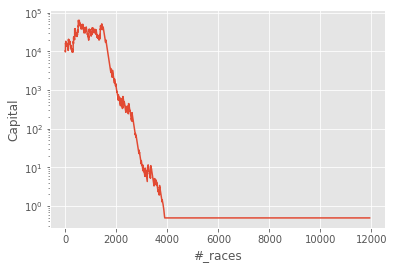

End capital: 0.49, exponential growth rate: -0.08%


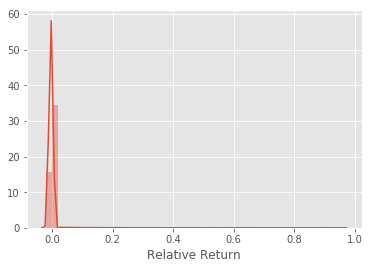

Capital is never null!


In [25]:
plot_scenario(best_expected_return_scenario_threshold_on_expected_return)

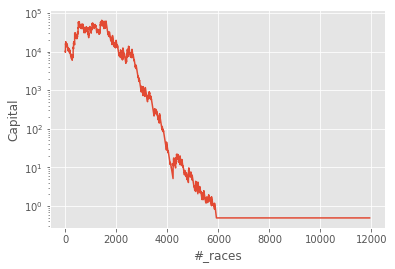

End capital: 0.49, exponential growth rate: -0.08%


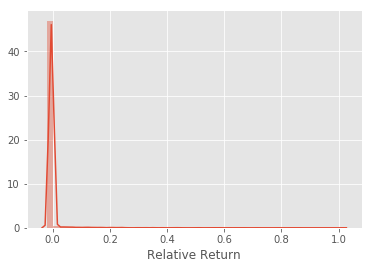

Capital is never null!


In [26]:
plot_scenario(best_expected_return_scenario_threshold_on_winning_proba)

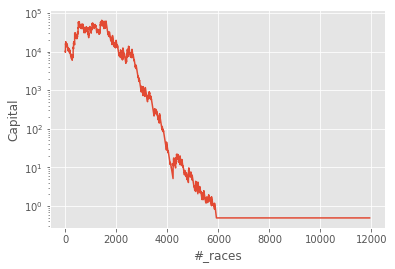

End capital: 0.49, exponential growth rate: -0.08%


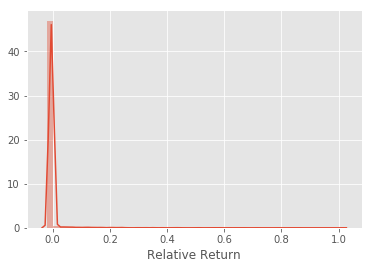

Capital is never null!


In [27]:
plot_scenario(best_expected_return_scenario_threshold_on_expected_return_winning_proba)

In [28]:
import wagering_stategies

In [29]:
%%time
not_max_odds_expected_return_df = compute_expected_return(compute_betting=wagering_stategies.race_betting_best_winning_proba_not_max_pari_mutual_proba,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model)



  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 34min 17s


In [30]:
not_max_odds_expected_return_df.expected_return.mean()

-0.0907807634441214

In [31]:
for n_horse, n_horse_er_df in not_max_odds_expected_return_df.groupby('n_horse'):
    print(n_horse,n_horse_er_df.expected_return.mean() , len(n_horse_er_df), f"{len(n_horse_er_df)/len(not_max_odds_expected_return_df):.2%}" )

3 0.6993376532012168 2 0.02%
4 -0.3082153973388827 30 0.25%
5 -0.2745554237148042 183 1.53%
6 0.1966081130974077 435 3.65%
7 -0.06104091435575559 772 6.47%
8 -0.04053379553373585 1060 8.89%
9 -0.14215971408017414 1044 8.75%
10 -0.15349414129866185 1262 10.58%
11 -0.012151143823416777 1164 9.76%
12 -0.11018261542281489 1452 12.17%
13 -0.039022527262313464 808 6.77%
14 -0.04539979963474662 1069 8.96%
15 -0.08105305308741147 621 5.21%
16 -0.10340828984072847 1360 11.40%
17 -0.5025900848636659 153 1.28%
18 -0.28175430785502176 477 4.00%
19 0.7012127357589321 9 0.08%
20 -1.0 23 0.19%
22 -1.0 1 0.01%
24 -1.0 4 0.03%


In [34]:
%%time
best_expected_return_scenario_threshold_on_winning_proba_expected_return = compute_expected_return(
    compute_betting=wagering_factories.betting_on_best_expected_return_thresholded_winning_probabilities_factory(minimum_winning_probabilities=0.05),
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 30min 20s


In [35]:
best_expected_return_scenario_threshold_on_winning_proba_expected_return.expected_return.mean()

-0.046043954515244144

In [36]:
for n_horse, n_horse_er_df in best_expected_return_scenario_threshold_on_winning_proba_expected_return.groupby('n_horse'):
    print(n_horse,n_horse_er_df.expected_return.mean() , len(n_horse_er_df), f"{len(n_horse_er_df)/len(best_expected_return_scenario_threshold_on_winning_proba_expected_return):.2%}" )

3 1.3711944089478063 2 0.02%
4 -0.4609364447733764 30 0.25%
5 -0.3662048531558592 183 1.53%
6 0.25582823637712543 435 3.65%
7 -0.03131424522031633 772 6.47%
8 -0.025060214950106848 1060 8.89%
9 -0.22705549043251547 1044 8.75%
10 -0.32700849845345203 1262 10.58%
11 0.1482445887449567 1164 9.76%
12 0.12055685854945264 1452 12.17%
13 0.0970075078401068 808 6.77%
14 -0.0038499881602815514 1069 8.96%
15 -0.09650926377231904 621 5.21%
16 -0.1757413552381712 1360 11.40%
17 -0.0368261601945615 153 1.28%
18 0.07909825611178554 477 4.00%
19 -1.0 9 0.08%
20 -1.0 23 0.19%
22 -1.0 1 0.01%
24 -1.0 4 0.03%


In [39]:
%%time
kelly_expected_return = compute_expected_return(
    compute_betting=wagering_stategies.race_bettings_kelly,
    source=SOURCE_PMU,
    code_pari="E_SIMPLE_GAGNANT",
    winning_model=winning_model,
) 

  0%|                                                                                                                                                                                                        | 0/24690 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 25min 34s


In [40]:
kelly_expected_return.mean()

sum_betting            0.854716
expected_return       -0.077860
n_horse               11.590242
race_id            95130.787828
dtype: float64

In [4]:
%%time
res={}
for minimum_winning_proba in np.arange(0.0, 0.11, 0.02):
    for minimum_expected_return in np.arange(0.0, 2.1, 1):
        e_r_df = compute_expected_return(
                    compute_betting_fun=wagering_factories.betting_on_best_expected_return_thresholded_winning_probabilities_expected_returns_factory(minimum_winning_probabilities=minimum_winning_proba, 
                                                                                                                                                      expected_return_threshold=minimum_expected_return),
                    source=SOURCE_PMU,
                    code_pari="E_SIMPLE_GAGNANT",
                    winning_model=winning_model,
                ) 
        print(minimum_winning_proba, minimum_expected_return, e_r_df.expected_return.mean())
        res[(minimum_winning_proba,minimum_expected_return)]=e_r_df.expected_return.mean()

  0%|                                                                                                                                                                                                        | 0/11929 [00:00<?, ?it/s]C:\Users\Mathieu\Desktop\Projets\Benter\utils\import_data.py:199: DtypeWarning: Columns (35,46,47,61,62,63,64,87) have mixed types.Specify dtype option on import or set low_memory=False.
  rh_df = get_split_date(source=source, on_split=on_split)
C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a

0.0 0.0 -0.06597597273891553


0.0 1.0 -0.05214771320689961


0.0 2.0 -0.0364703665987598


0.02 0.0 -0.05627586705106141


0.02 1.0 -0.03964035929813069


0.02 2.0 -0.023799735671446307


0.04 0.0 -0.00825153942593693


0.04 1.0 0.004949593683615623


0.04 2.0 0.01623805941419582


0.06 0.0 -0.04138895502434989


0.06 1.0 -0.010981071209778865


0.06 2.0 0.01883784936232334


0.08 0.0 0.0011205688120223337


0.08 1.0 0.029945562108639343


0.08 2.0 0.04534688681820681


0.1 0.0 0.003005453501181537


0.1 1.0 0.02689087667036832


0.1 2.0 0.047032900004700805
Wall time: 8h 3min


In [6]:
%%time
random_e_r_df = compute_expected_return(
                    compute_betting_fun=wagering_stategies.race_random_one_horse,
                    source=SOURCE_PMU,
                    code_pari="E_SIMPLE_GAGNANT",
                    winning_model=winning_model,
                ) 
random_e_r_df.expected_return.mean()

  0%|                                                                                                                                                                                                        | 0/11929 [00:00<?, ?it/s]C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Mathieu\Desktop\Projets\Benter\utils\preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ) / standard_

Wall time: 30min 27s


In [7]:
random_e_r_df.expected_return.mean()

-0.21328726289096558